In [1]:
import sys
sys.path.append('..')
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
%load_ext autoreload
%autoreload 2

In [33]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
from catboost import CatBoostClassifier
from scipy.special import logsumexp

from src.nf import (
    FCNN,
    ConditionalNormalizingFlowModel,
    cond_neg_log_likelihood,
    one_hot_encoding,
    ConditionalMAF,
    TorchDistributionWrapper,
    ConditionalNormal,
    TorchDistributionWrapper,
    NormalizingFlowModel,
    MAF,
    BaseConditionalFlow,
    wrap_cb,
    ConditionalCalibratedModel,
    deduce_calibration_constant
)

import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
! nvidia-smi

Sat May 23 21:16:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0 Off |                  N/A |
| 20%   44C    P5    12W / 250W |    585MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
| 20%   27C    P8     8W / 250W |      2MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

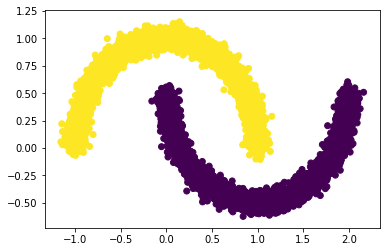

In [6]:
X, Y = make_moons(10000)
Y = one_hot_encoding(Y, 2).astype(np.float32)
n, dim, cond_dim = X.shape[0], X.shape[1], Y.shape[1]
X += np.random.normal(0, 0.05, X.shape)
X = X.astype(np.float32)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train[:, 0])

In [7]:
X_train_tensor = torch.from_numpy(X_train).to(device)
X_test_tensor = torch.from_numpy(X_test).to(device)
Y_train_tensor = torch.from_numpy(Y_train).to(device)
Y_test_tensor = torch.from_numpy(Y_test).to(device)

In [8]:
flows = []
for i in range(2):
    flows.append(ConditionalMAF(dim, cond_dim).to(device))

prior = ConditionalNormal(
    torch.zeros(dim).to(device), torch.eye(dim).to(device),
    FCNN(cond_dim, dim, 8), FCNN(cond_dim, dim, 8)
).to(device)
model = ConditionalNormalizingFlowModel(dim, cond_dim, prior, flows).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [9]:
epoches = 501
metrics_ll_train, metrics_ll_test = [], []

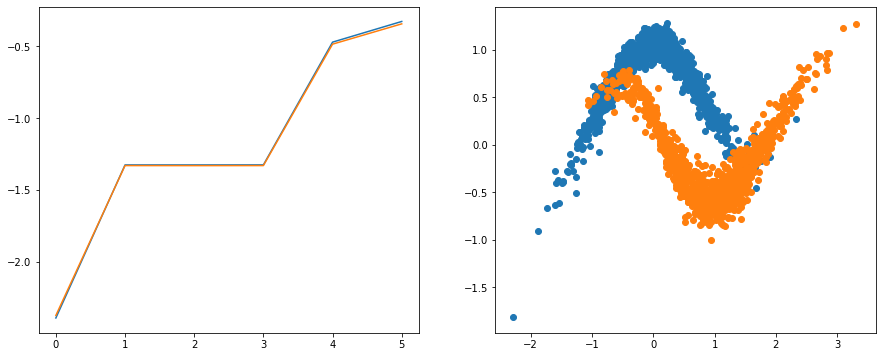

In [10]:
for i in range(len(metrics_ll_train), epoches):
    model.train()
    optimizer.zero_grad()
    z, logp_z, log_det = model(X_train_tensor, Y_train_tensor)
    logp_x = logp_z + log_det
    loss = -torch.mean(logp_x)
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        model.eval()
        with torch.no_grad():
            _, logp_z, log_det = model(X_train_tensor, Y_train_tensor)
            metrics_ll_train.append(torch.mean(logp_z + log_det).item())
            _, logp_z, log_det = model(X_test_tensor, Y_test_tensor)
            metrics_ll_test.append(torch.mean(logp_z + log_det).item())
            
            n_samples = 1000
            condition = one_hot_encoding(np.zeros(n_samples, dtype=np.uint32), 2, True).to(device)
            z = prior.sample_n(n_samples, condition)
            samples_1, _ = model.backward(
                z, condition
            )
            samples_1 = samples_1.detach().cpu().numpy()
            
            condition = one_hot_encoding(np.ones(n_samples, dtype=np.uint32), 2, True).to(device)
            z = prior.sample_n(n_samples, condition)
            samples_2, _ = model.backward(
                z, condition
            )
            samples_2 = samples_2.detach().cpu().numpy()

        clear_output(False)
        fig, axs = plt.subplots(1, 2, figsize=(15, 6))
        
        axs[0].plot(metrics_ll_train)
        axs[0].plot(metrics_ll_test)
        
        axs[1].scatter(samples_1[:, 0], samples_1[:, 1])
        axs[1].scatter(samples_2[:, 0], samples_2[:, 1])
        plt.show()

In [11]:
real_data = np.hstack([X_train, Y_train])

model.eval()
with torch.no_grad():
    n_samples = real_data.shape[0]

    condition_0 = one_hot_encoding(np.zeros(n_samples // 2, dtype=np.uint32), 2, True).to(device)
    z = prior.sample_n(n_samples // 2, condition_0)
    samples_0, _ = model.backward(z, condition_0)
    samples_0 = samples_0.detach().cpu().numpy()
    gen_data_0 = np.hstack([samples_0, condition_0.cpu().numpy()])
    
    condition_1 = one_hot_encoding(np.ones(n_samples // 2, dtype=np.uint32), 2, True).to(device)
    z = prior.sample_n(n_samples // 2, condition_1)
    samples_1, _ = model.backward(z, condition_1)
    samples_1 = samples_1.detach().cpu().numpy()
    gen_data_1 = np.hstack([samples_1, condition_1.cpu().numpy()])

X_clf = np.vstack([real_data, gen_data_0, gen_data_1])
Y_clf = np.hstack([np.ones(real_data.shape[0]), np.zeros(real_data.shape[0])])

X_train_clf, X_test_clf, Y_train_clf, Y_test_clf = train_test_split(X_clf, Y_clf, test_size=0.2)

In [12]:
X_clf.shape

(16000, 4)

In [13]:
clf = CatBoostClassifier(
    100, eval_metric='AUC',
    metric_period=10,
    use_best_model=False
).fit(
    X_train_clf, Y_train_clf,
    eval_set=(X_test_clf, Y_test_clf)
)

Learning rate set to 0.268204
0:	test: 0.6426960	best: 0.6426960 (0)	total: 58.1ms	remaining: 5.75s
10:	test: 0.7433611	best: 0.7433611 (10)	total: 82.8ms	remaining: 670ms
20:	test: 0.7676111	best: 0.7676111 (20)	total: 104ms	remaining: 393ms
30:	test: 0.7805728	best: 0.7805728 (30)	total: 125ms	remaining: 278ms
40:	test: 0.7873485	best: 0.7873485 (40)	total: 144ms	remaining: 207ms
50:	test: 0.7921391	best: 0.7921391 (50)	total: 163ms	remaining: 157ms
60:	test: 0.7937384	best: 0.7937384 (60)	total: 183ms	remaining: 117ms
70:	test: 0.7952488	best: 0.7952488 (70)	total: 203ms	remaining: 82.8ms
80:	test: 0.7960948	best: 0.7960948 (80)	total: 221ms	remaining: 51.9ms
90:	test: 0.7973170	best: 0.7973170 (90)	total: 240ms	remaining: 23.7ms
99:	test: 0.7981257	best: 0.7981257 (99)	total: 256ms	remaining: 0us

bestTest = 0.798125676
bestIteration = 99



In [14]:
calibration_constant_0 = deduce_calibration_constant(wrap_cb(clf), gen_data_0)
calibration_constant_1 = deduce_calibration_constant(wrap_cb(clf), gen_data_1)

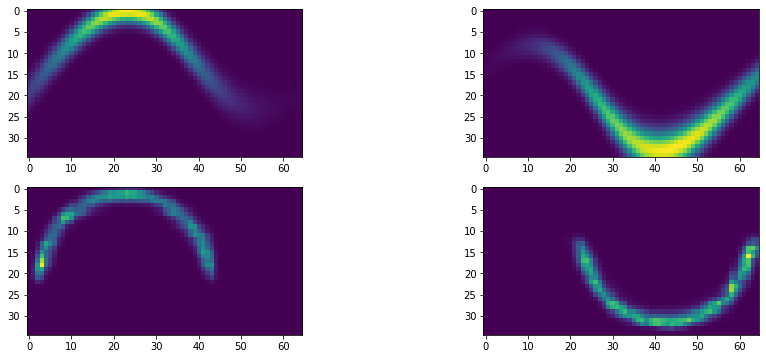

In [15]:
X_val = np.transpose(np.dstack(np.meshgrid(
        np.arange(np.min(X_test[:, 0]), np.max(X_test[:, 0]), 0.05),
        np.arange(np.min(X_test[:, 1]), np.max(X_test[:, 1]), 0.05),
    )), axes=[1, 0, 2]).astype(np.float32)

logits_1 = clf.predict(
    np.hstack([X_val.reshape(-1, 2), one_hot_encoding(np.ones(X_val.reshape(-1, 2).shape[0], dtype=np.uint8), 2)]),
    prediction_type='RawFormulaVal'
)
logits_0 = clf.predict(
    np.hstack([X_val.reshape(-1, 2), one_hot_encoding(np.zeros(X_val.reshape(-1, 2).shape[0], dtype=np.uint8), 2)]),
    prediction_type='RawFormulaVal'
)

model.eval()
with torch.no_grad():
    _, logp_z, log_det = model(
        torch.from_numpy(
            X_val.reshape(-1, 2),
        ).to(device),
        one_hot_encoding(np.zeros(X_val.reshape(-1, 2).shape[0], dtype=np.uint8), 2, True).to(device)
    )
    log_probs_0 = logp_z + log_det
    log_probs_0 = log_probs_0.detach().cpu().numpy()
    probs_0 = np.exp(log_probs_0).reshape(X_val.shape[0], X_val.shape[1])
    probs_0_fixed = np.exp(log_probs_0 + logits_0 - calibration_constant_0).reshape(X_val.shape[0], X_val.shape[1])

    _, logp_z, log_det = model(
        torch.from_numpy(
            X_val.reshape(-1, 2),
        ).to(device),
        one_hot_encoding(np.ones(X_val.reshape(-1, 2).shape[0], dtype=np.uint8), 2, True).to(device)
    )
    log_probs_1 = logp_z + log_det
    log_probs_1 = log_probs_1.detach().cpu().numpy()
    probs_1 = np.exp(log_probs_1).reshape(X_val.shape[0], X_val.shape[1])
    probs_1_fixed = np.exp(log_probs_1 + logits_1 - calibration_constant_1).reshape(X_val.shape[0], X_val.shape[1])
    

fig, axs = plt.subplots(2, 2, figsize=(15, 6))

axs[0, 0].imshow(probs_0.T[::-1])
axs[0, 1].imshow(probs_1.T[::-1])

axs[1, 0].imshow(probs_0_fixed.T[::-1])
axs[1, 1].imshow(probs_1_fixed.T[::-1])

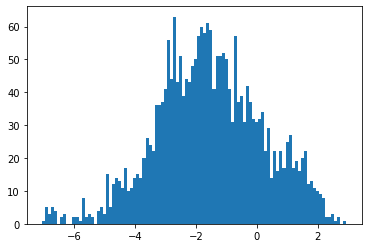

In [18]:
plt.hist(logits_0, bins=100);

In [28]:
calib_model = ConditionalCalibratedModel(wrap_cb(clf, np.log(4)), model, np.log(4))

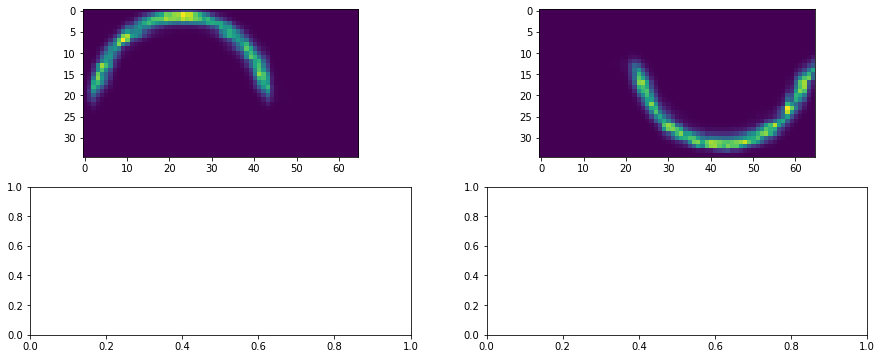

In [29]:
X_val = np.transpose(np.dstack(np.meshgrid(
    np.arange(np.min(X_test[:, 0]), np.max(X_test[:, 0]), 0.05),
    np.arange(np.min(X_test[:, 1]), np.max(X_test[:, 1]), 0.05),
)), axes=[1, 0, 2]).astype(np.float32)

model.eval()
with torch.no_grad():
    log_probs_0 = calib_model.log_prob(
        X_val.reshape(-1, 2),
        one_hot_encoding(np.zeros(X_val.reshape(-1, 2).shape[0], dtype=np.uint8), 2)
    )
    probs_0 = np.exp(log_probs_0).reshape(X_val.shape[0], X_val.shape[1])

    log_probs_1 = calib_model.log_prob(
        X_val.reshape(-1, 2),
        one_hot_encoding(np.ones(X_val.reshape(-1, 2).shape[0], dtype=np.uint8), 2)
    )
    probs_1 = np.exp(log_probs_1).reshape(X_val.shape[0], X_val.shape[1])

fig, axs = plt.subplots(2, 2, figsize=(15, 6))

axs[0, 0].imshow(probs_0.T[::-1])
axs[0, 1].imshow(probs_1.T[::-1])

# axs[1, 0].imshow(probs_0_fixed.T[::-1])
# axs[1, 1].imshow(probs_1_fixed.T[::-1])